In [16]:
import numpy as np
import importlib
import matplotlib.cm as cm
import time
from IPython.display import Video
import eval_env
from bcolors import bcolors as bcolors

import ca_environment as caenv
import ca_agent as caag

import neat
import neat_stuff.visualize as visualize
import os

In [30]:
importlib.reload(caenv)
importlib.reload(caag)
importlib.reload(visualize)

<module 'neat_stuff.visualize' from '/Users/aidanbarbieux/CSC/580-CSC/WIDDAK/nca/neat_stuff/visualize.py'>

In [20]:
print(("aa: " + bcolors.HEADER + "{0}" + bcolors.ENDC +
"\n\tbb: " + bcolors.WARNING + "{1}" + bcolors.ENDC).format('qsdasd','asdasdas'))

aa: qsdasd
	bb: asdasdas


ENVIRONMENT: slime_eg


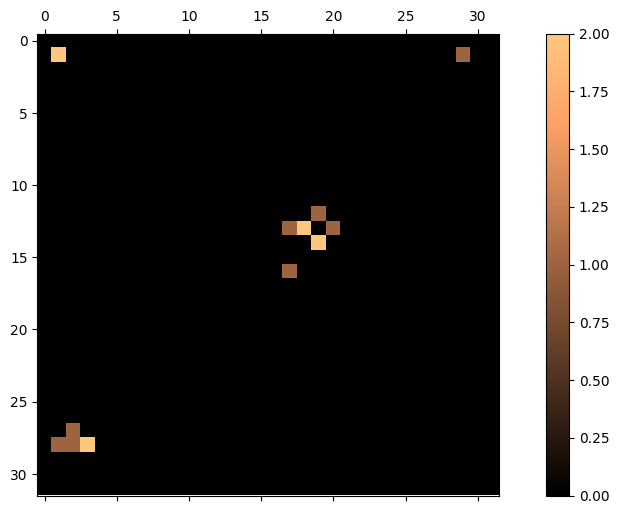

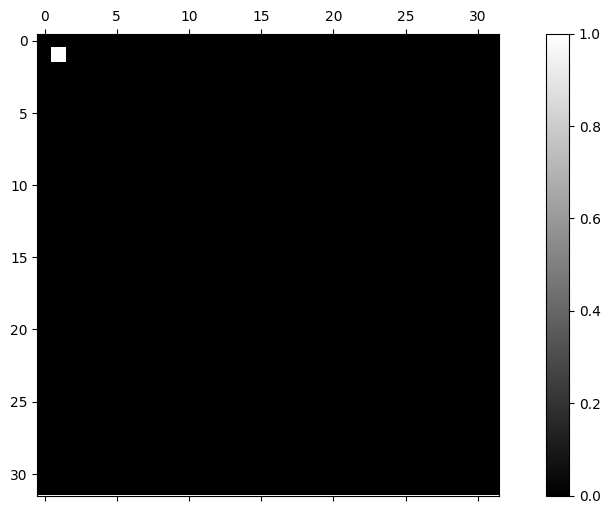

In [11]:
env = caenv.CAEnvironment("slime_eg")
env.gen_padded_food()
env.innoculate()
env.display()


In [27]:
ag = caag.CAAgent("Lame Agent")
def lame_rules(chunk, env):
    return [1] * env.n_channels

ag.set_rule_func(lame_rules)

rag = caag.CAAgent("Random Agent")
def rand_rules(chunk, env):
    return np.random.random(env.n_channels)
rag.set_rule_func(rand_rules)

In [28]:
print(ag.display())


CAAgent ID: Lame Agent
	KERNEL: von_n
	AGENT_TYPE: slime mold


In [5]:
env.start_new_video(channels=(env.food_i, env.life_i), cmaps = (cm.copper,cm.gray))
for _ in range(30):
    # ag.apply_to_env(env, log=True, vid_speed=3)
    rag.apply_to_env(env, log=True, vid_speed=5)

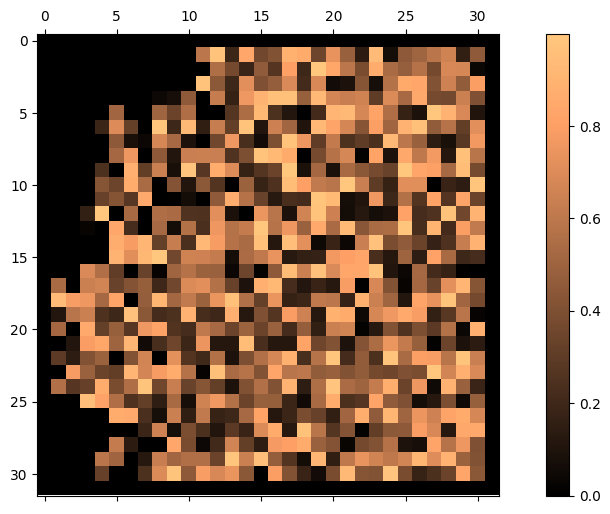

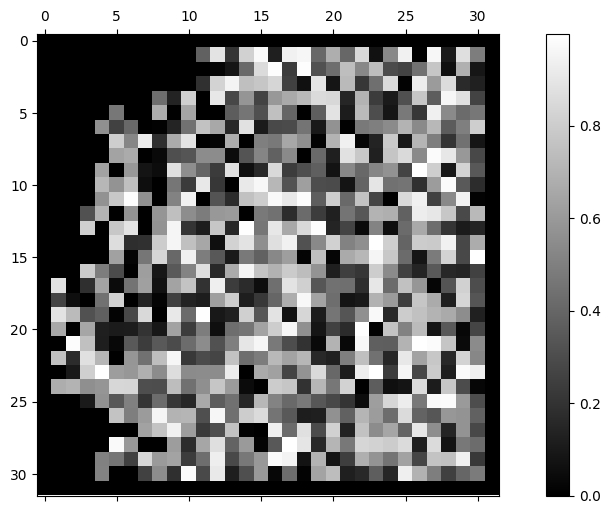

In [6]:
env.display()

In [7]:
Video(env.gen_video())

2022-11-05 12:24:34.587383: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


3
	 1
ENVIRONMENT: test_F_3-L_1
	 2
ENVIRONMENT: test_F_3-L_2
2
	 2
ENVIRONMENT: test_F_2-L_2
	 3
ENVIRONMENT: test_F_2-L_3
	 1
ENVIRONMENT: test_F_2-L_1
	 4
ENVIRONMENT: test_F_2-L_4
1
	 1
ENVIRONMENT: test_F_1-L_1
	 2
ENVIRONMENT: test_F_1-L_2
	 3
ENVIRONMENT: test_F_1-L_3
5
	 1
ENVIRONMENT: test_F_5-L_1
	 2
ENVIRONMENT: test_F_5-L_2
4
	 3
ENVIRONMENT: test_F_4-L_3


/Users/aidanbarbieux/CSC/580-CSC/WIDDAK/nca/ca_environment.py:211: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # fig, axes = plt.subplots(ncols=2, figsize=(12, 6))


	 2
ENVIRONMENT: test_F_4-L_2
	 1
ENVIRONMENT: test_F_4-L_1


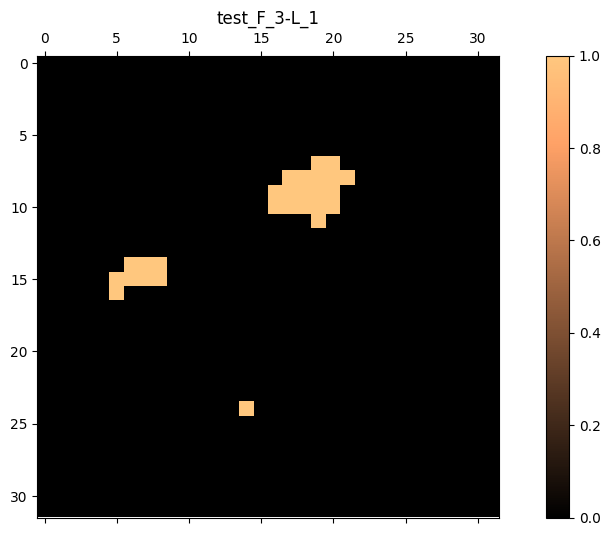

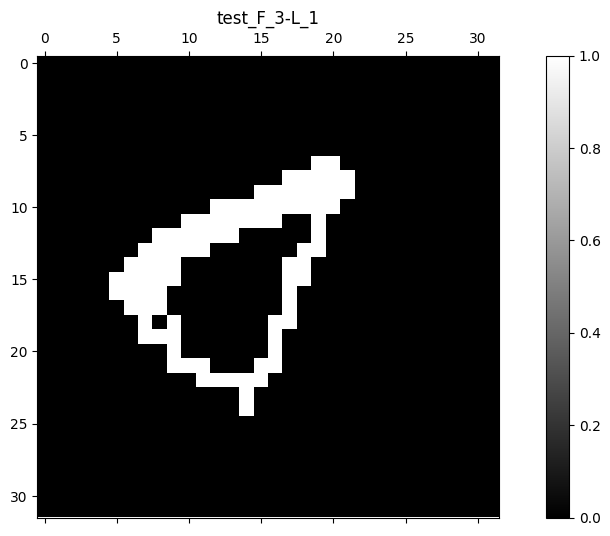

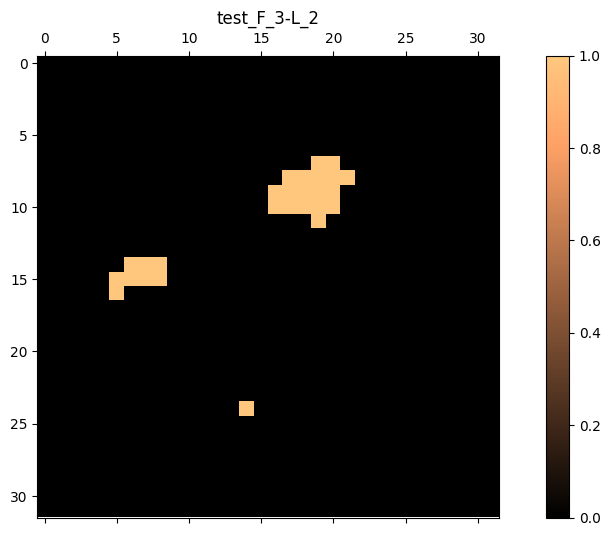

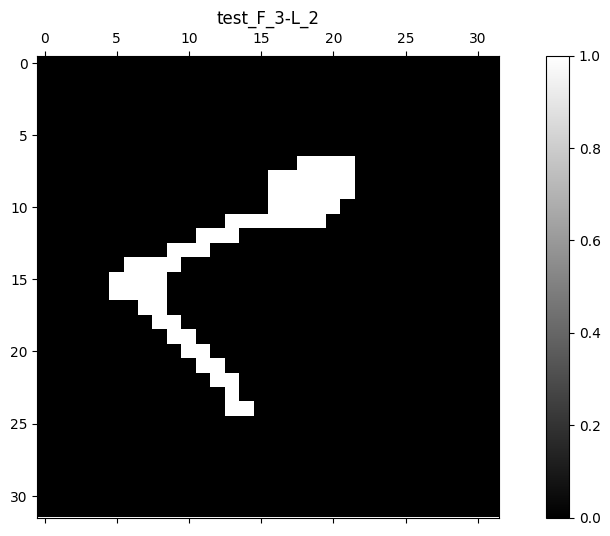

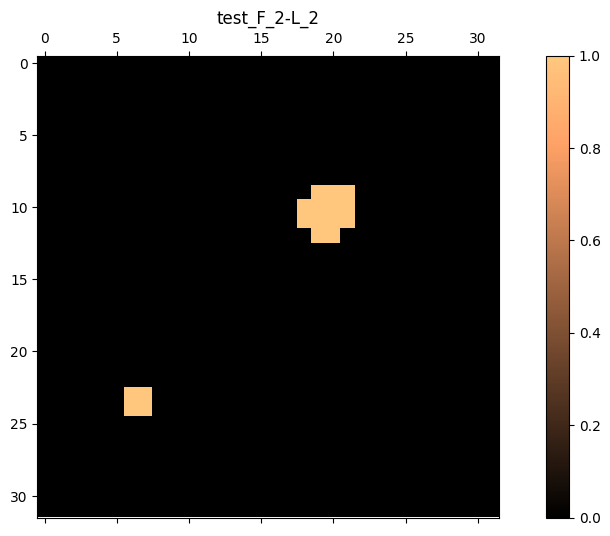

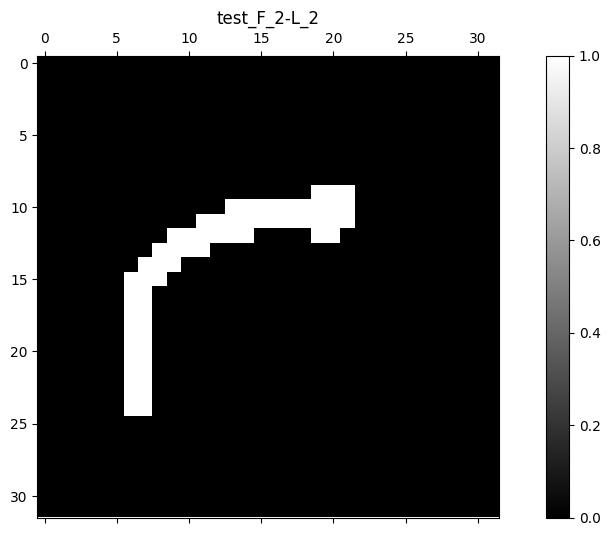

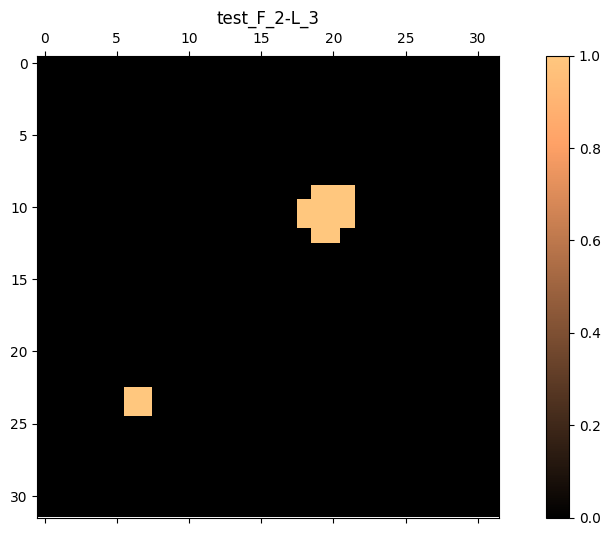

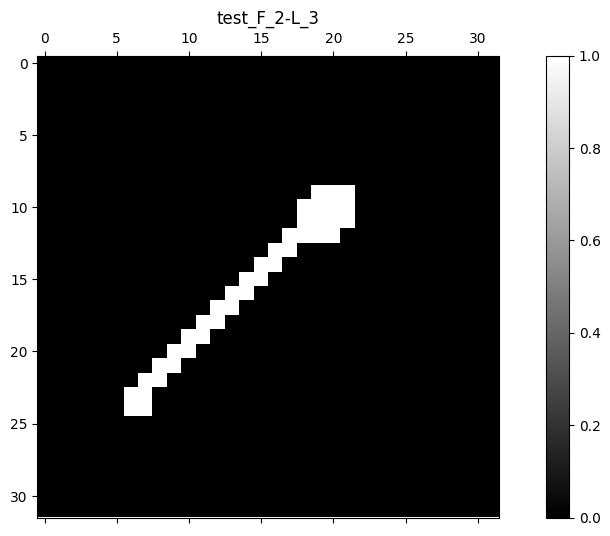

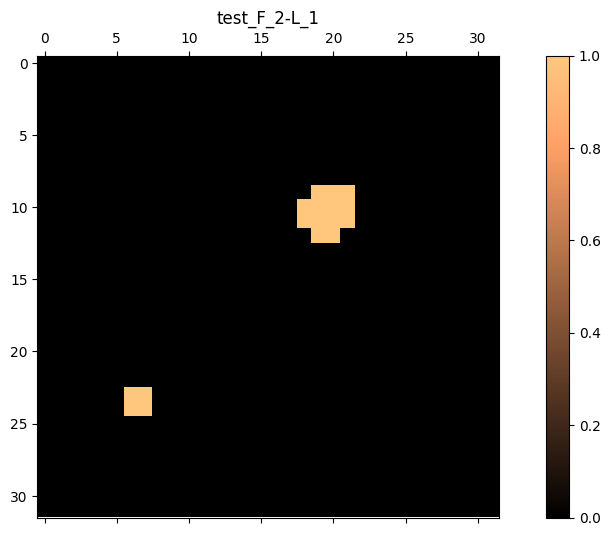

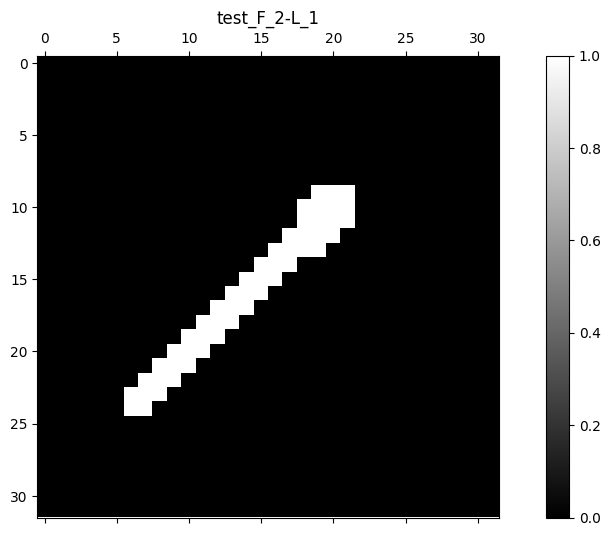

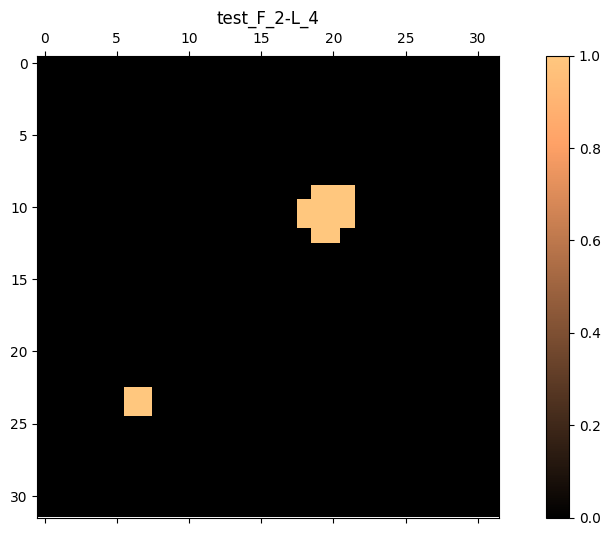

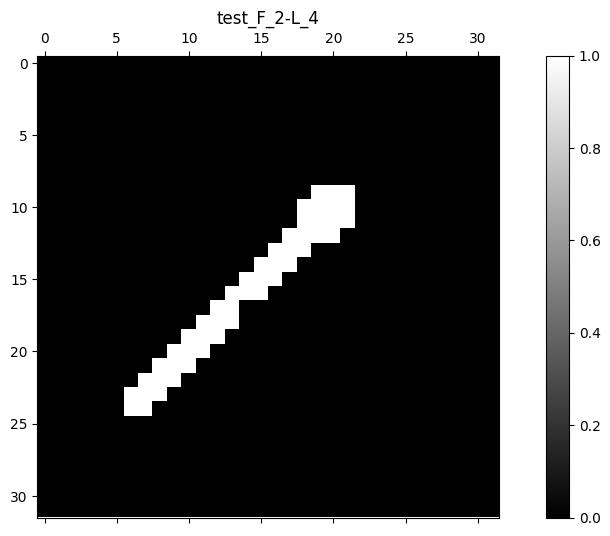

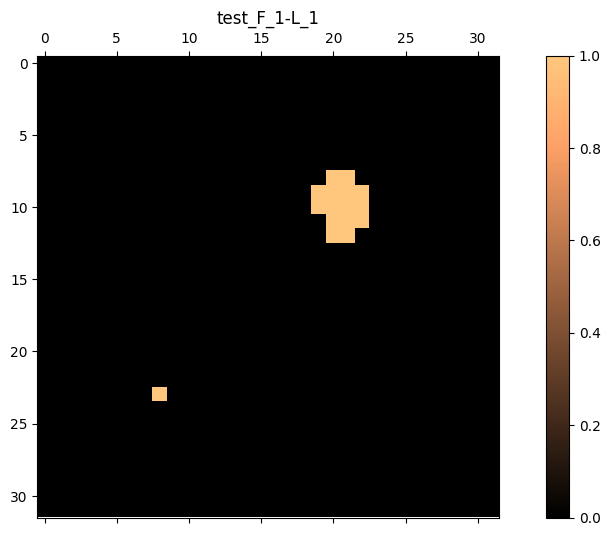

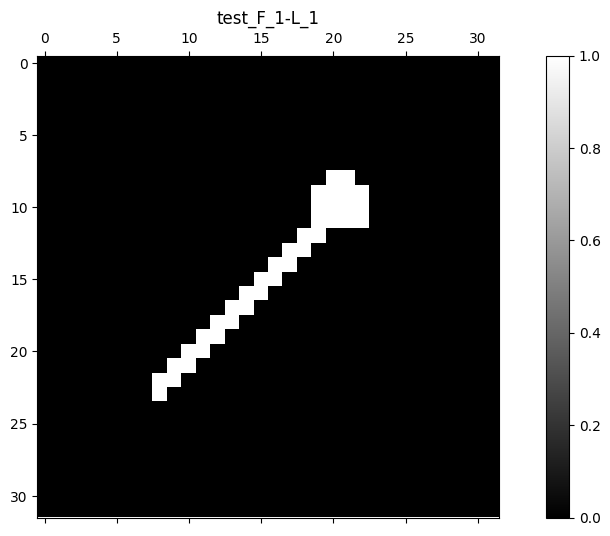

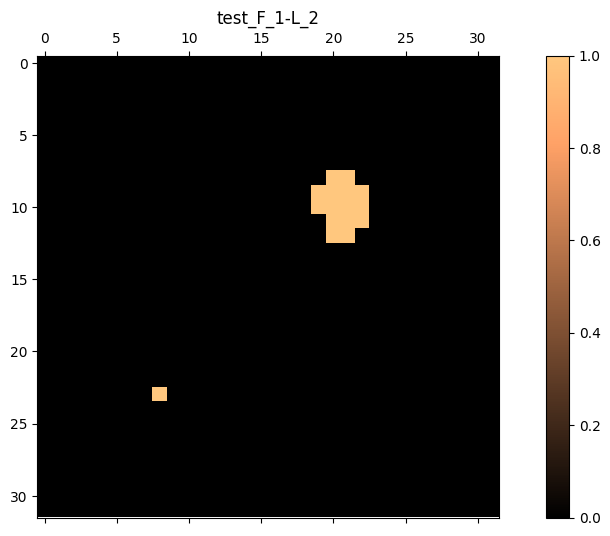

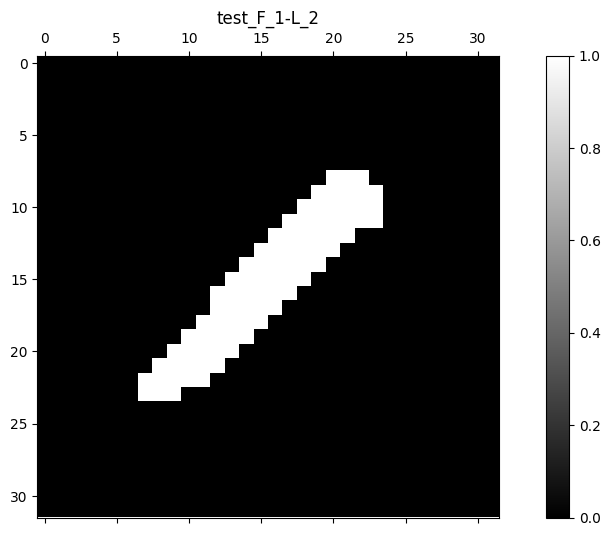

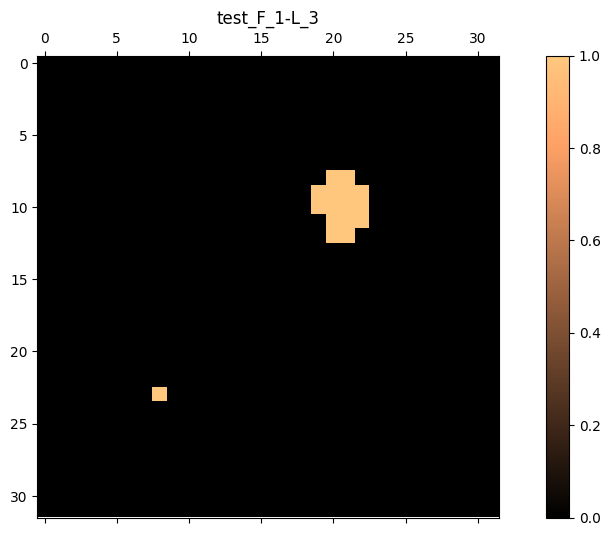

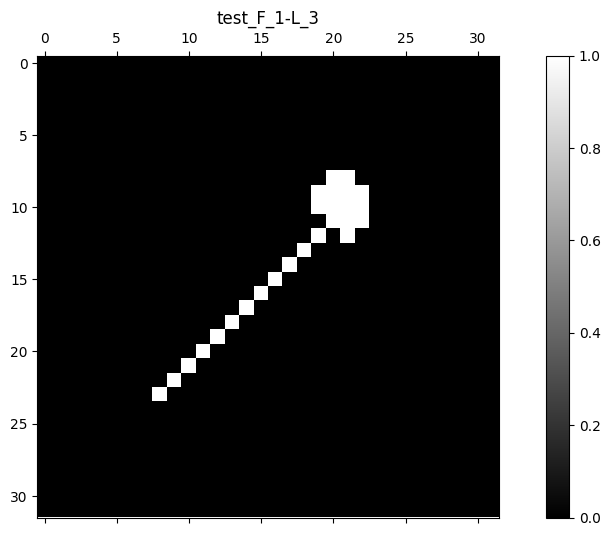

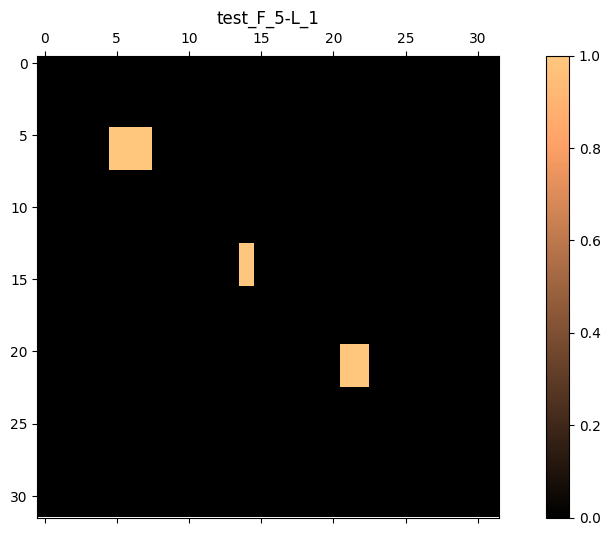

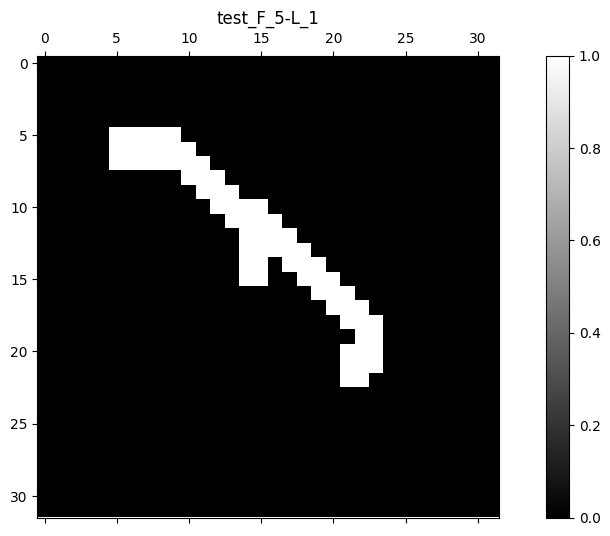

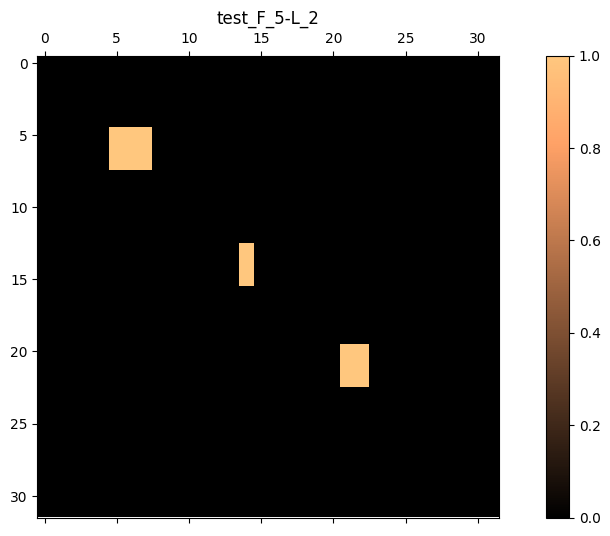

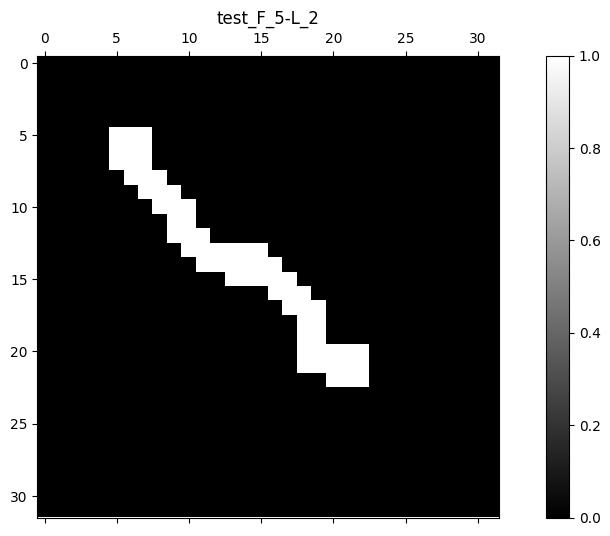

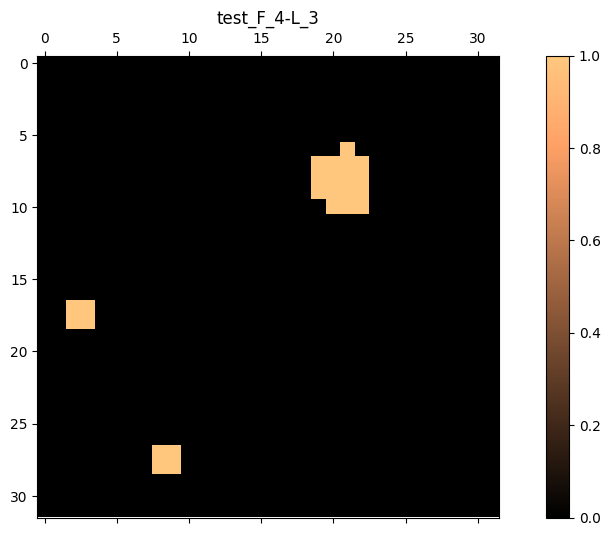

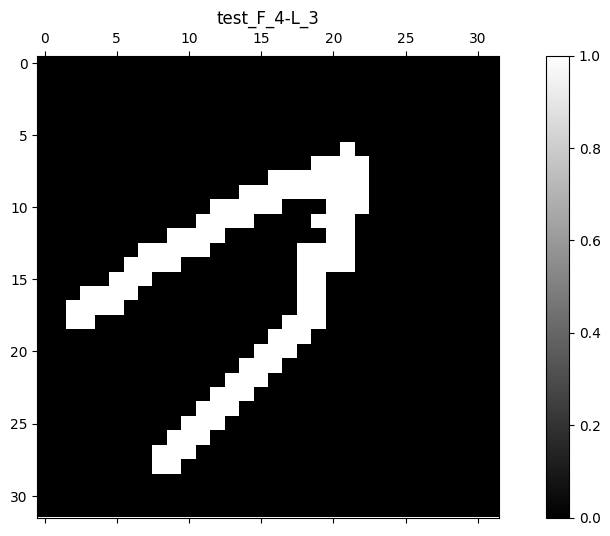

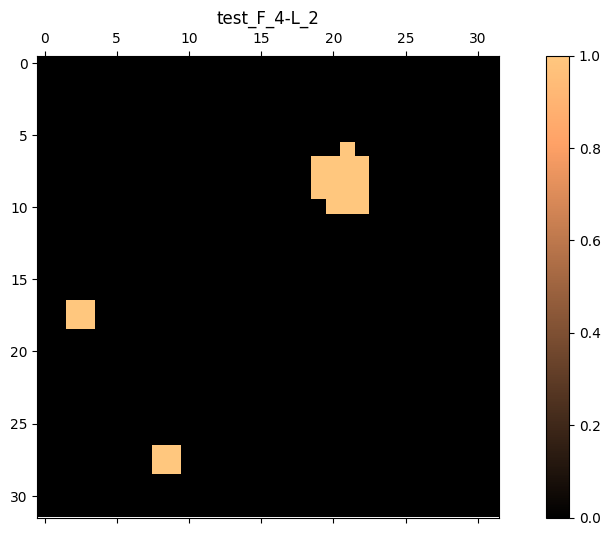

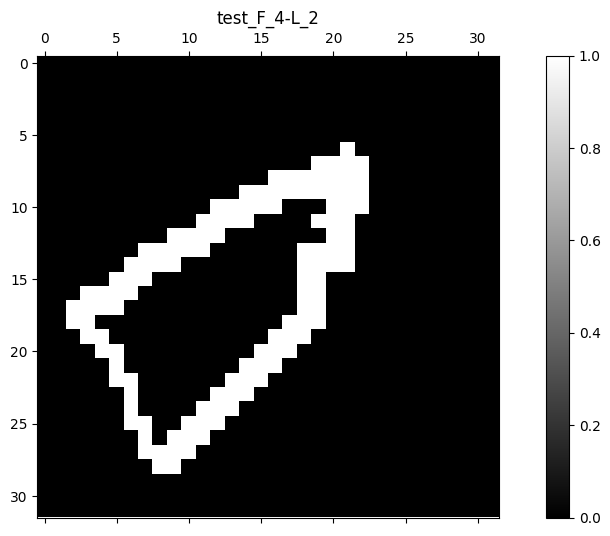

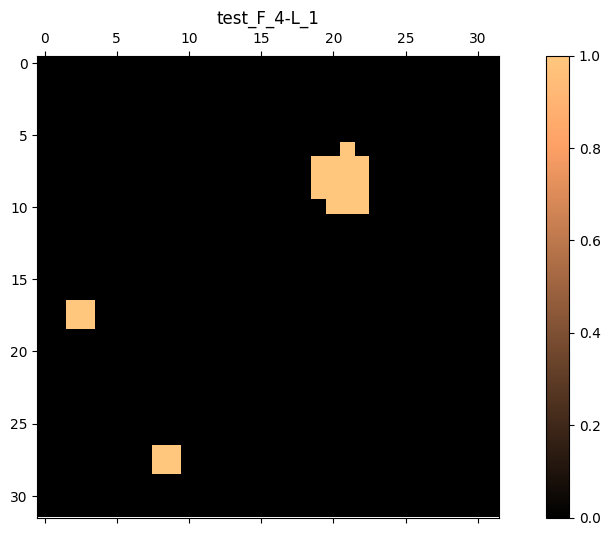

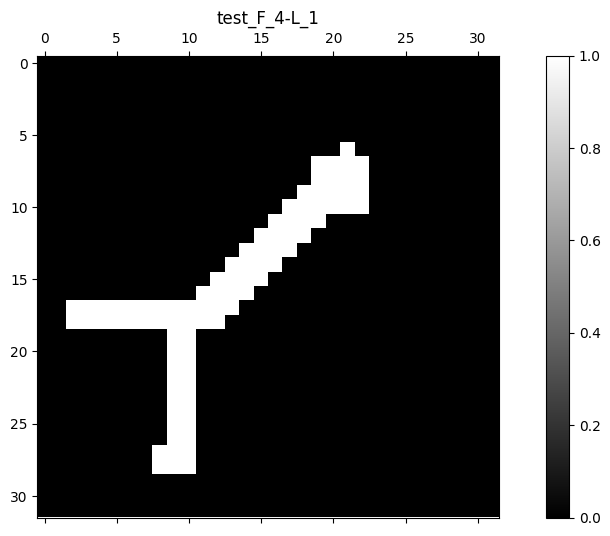

In [163]:
importlib.reload(eval_env)
tenvs = eval_env.load_tests()
for fkey in tenvs.keys():
    print(fkey)
    for ekey in tenvs[fkey].keys():
        print("\t",ekey)
        tenvs[fkey][ekey].display()

ENVIRONMENT: test_F_4-L_1


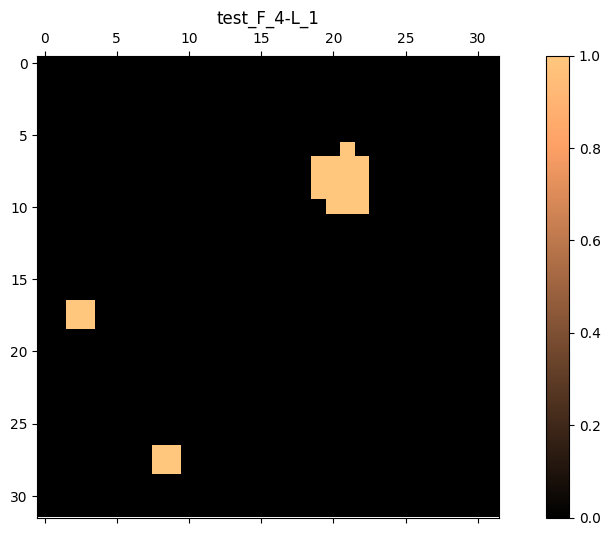

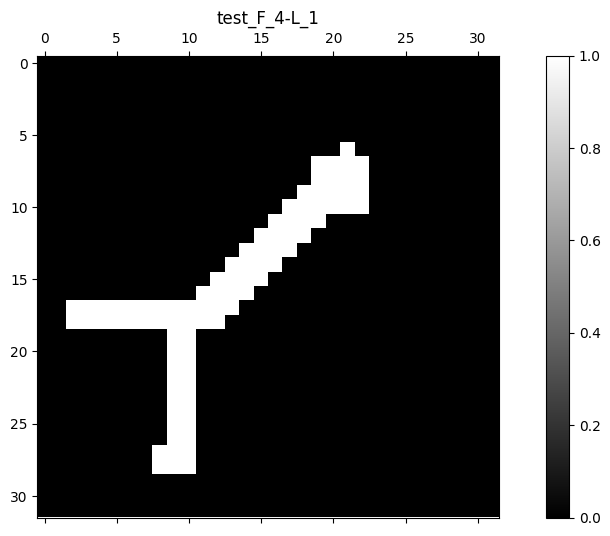

In [164]:
tenv = tenvs['4']['1']
tenv.display()

ENVIRONMENT: test_F_4-L_1
ENVIRONMENT: test_F_4-L_1
ENVIRONMENT: test_F_4-L_1
ENVIRONMENT: test_F_4-L_1
ENVIRONMENT: test_F_4-L_1
ENVIRONMENT: test_F_4-L_1
ENVIRONMENT: test_F_4-L_1
ENVIRONMENT: test_F_4-L_1
ENVIRONMENT: test_F_4-L_1
ENVIRONMENT: test_F_4-L_1


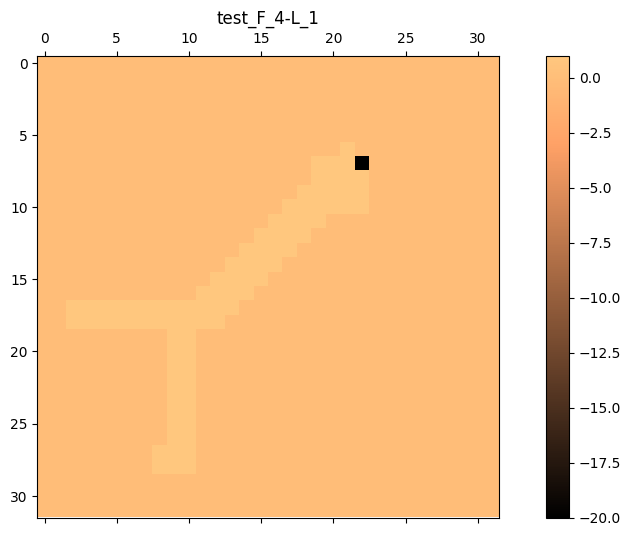

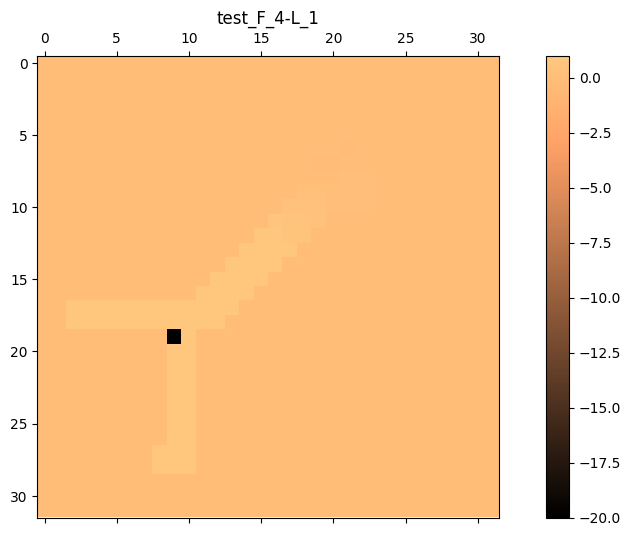

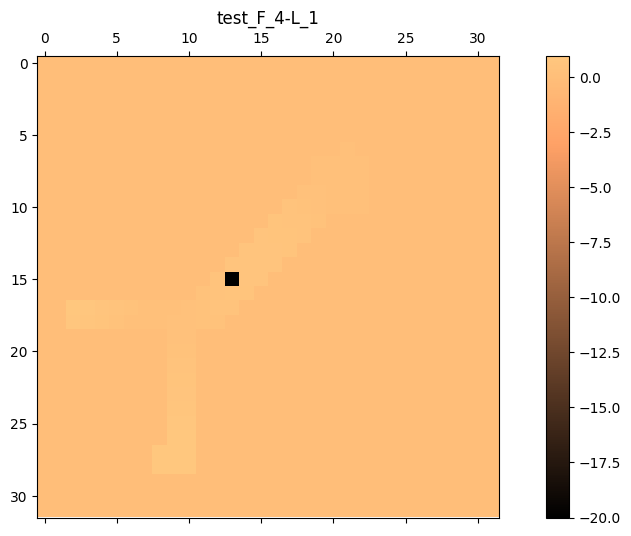

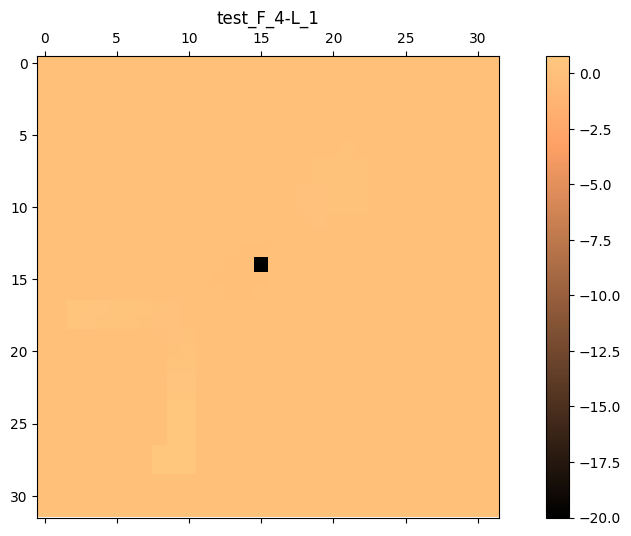

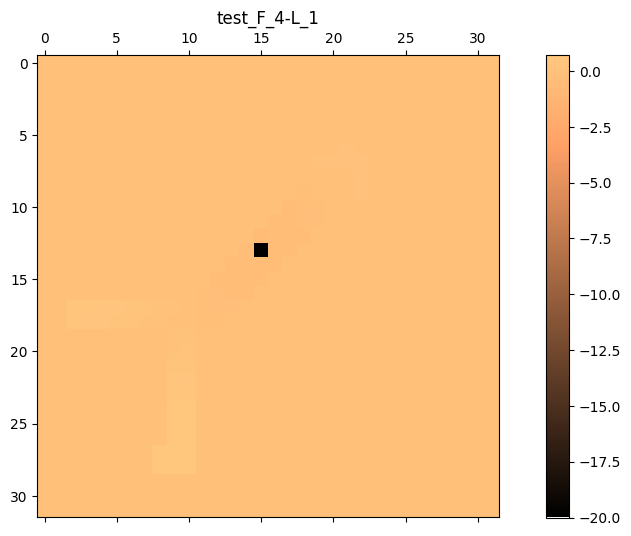

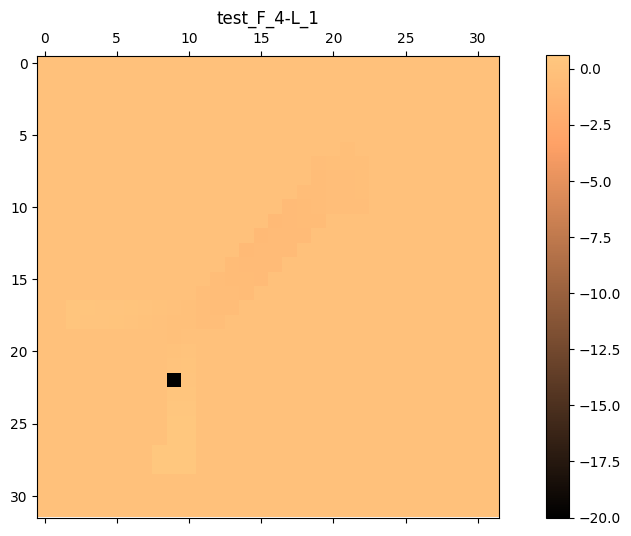

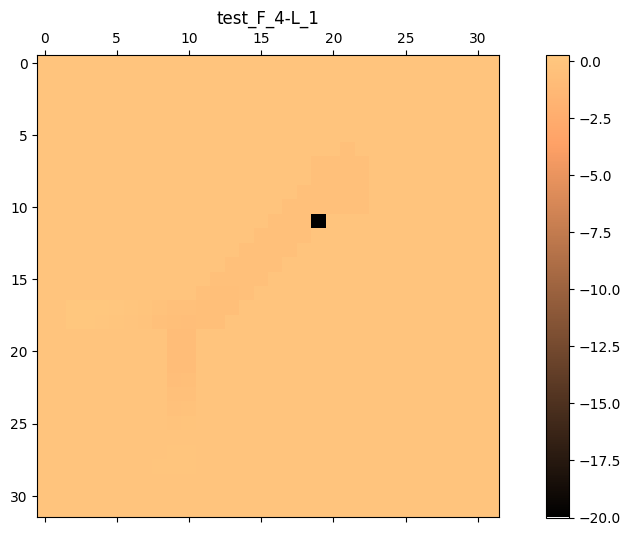

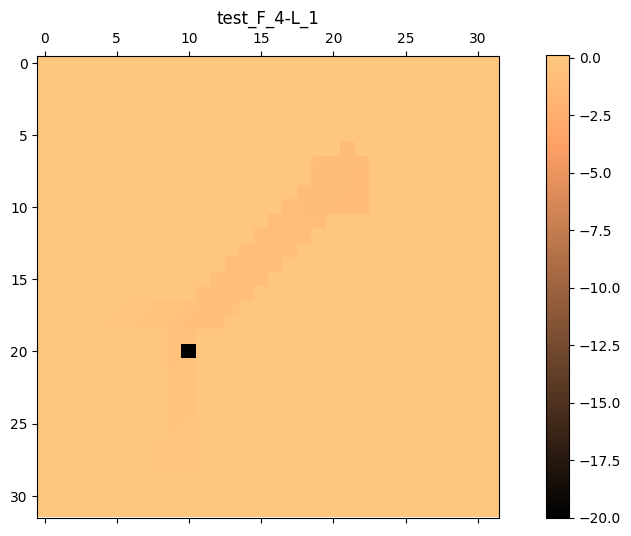

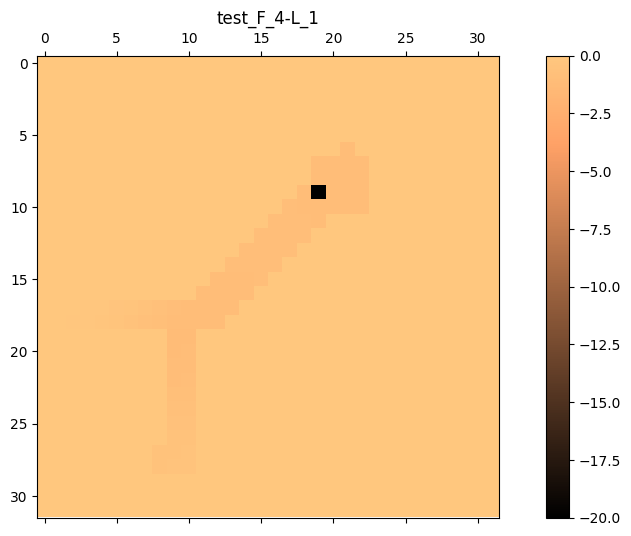

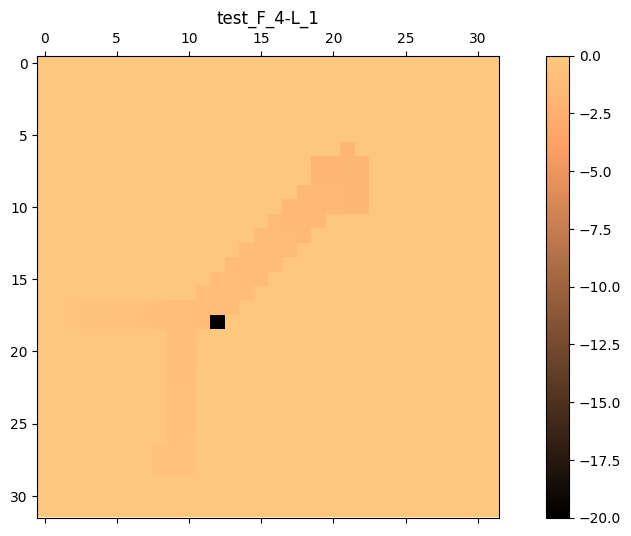

In [239]:
von_n = (np.array([-1,  0,  0, 1]),
         np.array([0, -1,  1,  0]))  # Von Neumann neighborhood indices

tenv.channels[tenv.hidden_i] *= 0
life_inds = tenv.channels[tenv.life_i].nonzero()
# food_inds = (tenv.channels[tenv.food_i]).nonzero()
tenv.channels[tenv.hidden_i,life_inds[0],life_inds[1]] = 1 # Fill resevoirs
# tenv.channels[tenv.hidden_i,life_inds]

# victim = np.random.randint(0,len(life_inds[0]))
# victim = (life_inds[0][victim],life_inds[1][victim])
# tenv.channels[tenv.hidden_i,victim[0],victim[1]] = -5 # Draw from one resevoir
# tenv.display(channels=[tenv.hidden_i])


tenv.start_new_video(channels = (tenv.life_i,tenv.hidden_i), cmaps=(cm.gray,cm.hot))

for _ in range(10): # draw from 10 cells
    victim = np.random.randint(0,len(life_inds[0]))
    victim = (life_inds[0][victim],life_inds[1][victim])
    tenv.channels[tenv.hidden_i,victim[0],victim[1]] = -20 # Draw from one resevoir
    tenv.display(channels=[tenv.hidden_i])
    # Propogate draw for 10 moves:
    for f in range(10):
        neg_cells = ((tenv.channels[tenv.hidden_i] < 1) * (tenv.channels[tenv.life_i] > 0)).nonzero()
        for i,j in zip(neg_cells[0],neg_cells[1]):
            for n in range(len(von_n[0])):
                if tenv.channels[tenv.life_i,von_n[0][n] + i, von_n[1][n] + j]>0:
                    val = tenv.channels[tenv.hidden_i, i, j]
                    nval = tenv.channels[tenv.hidden_i, von_n[0][n] + i, von_n[1][n] + j]

                    tenv.channels[tenv.hidden_i, i, j] += (nval - val)/2
                    tenv.channels[tenv.hidden_i, von_n[0][n] + i, von_n[1][n] + j] += (val-nval)/2
        if f%1 == 0:
            tenv.channels[tenv.hidden_i, 0,0] = -20
            tenv.add_state_to_video()
            tenv.channels[tenv.hidden_i, 0,0] = 0
    # if f%1 == 0:
    #     tenv.channels[tenv.hidden_i, 0,0] = -5
    #     tenv.add_state_to_video()
    #     tenv.channels[tenv.hidden_i, 0,0] = 0
# tenv.display(channels=[tenv.hidden_i])

In [240]:
Video(tenv.gen_video())
